In [4]:
import pandas as pd
import os
import numpy as np


# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [5]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room', 'op code']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

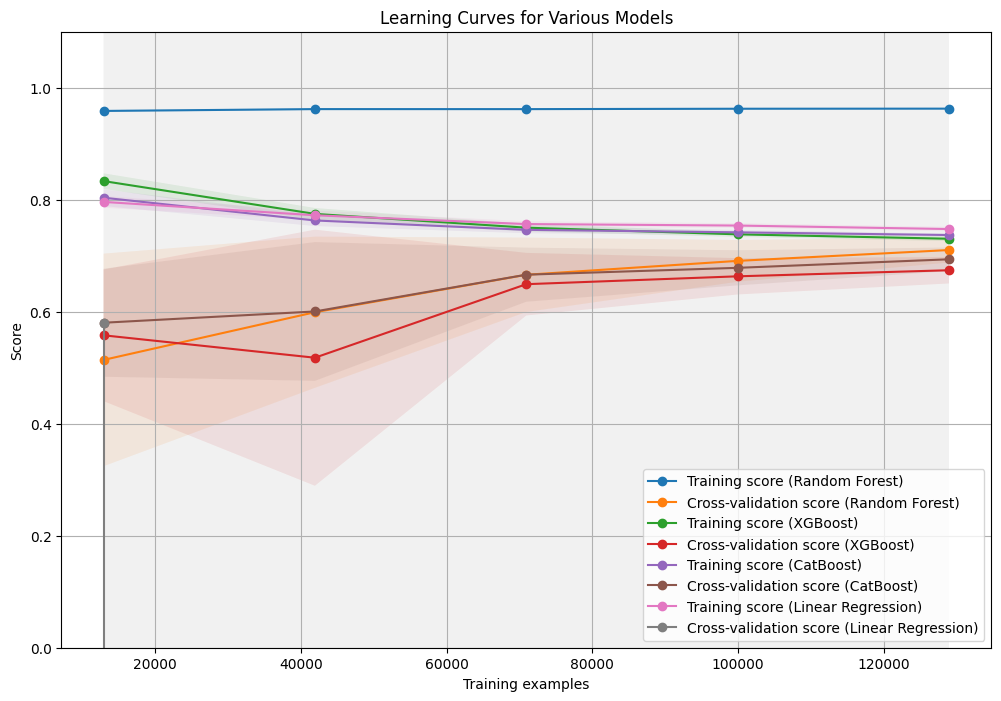

In [6]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label=f"Training score ({title})")
    plt.plot(train_sizes, test_scores_mean, 'o-', label=f"Cross-validation score ({title})")

# 데이터 준비
X = df_encoded.drop('surgery duration', axis=1)
y = df_encoded['surgery duration']

# 모델 설정
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "Linear Regression": LinearRegression()
}

# 그래프 설정
plt.figure(figsize=(12, 8))
plt.title("Learning Curves for Various Models")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)

# 각 모델의 학습 곡선 그리기
for name, estimator in models.items():
    plot_learning_curve(estimator, name, X, y, cv=5)

plt.legend(loc="best")
plt.grid()
plt.show()


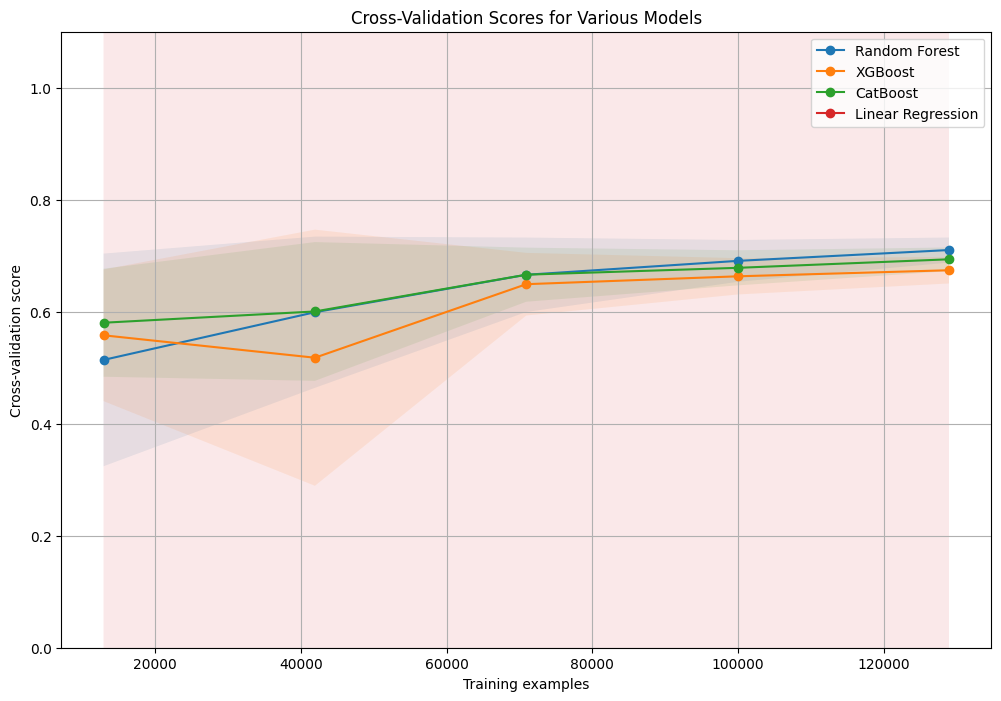

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 그래프 설정
plt.figure(figsize=(12, 8))
plt.title("Cross-Validation Scores for Various Models")
plt.xlabel("Training examples")
plt.ylabel("Cross-validation score")
plt.ylim(0.0, 1.1)

# 각 모델의 교차 검증 점수 그리기
for name, estimator in models.items():
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, test_scores_mean, 'o-', label=f"{name}")

plt.legend(loc="best")
plt.grid()
plt.show()


In [8]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# 점수 계산을 위한 함수
def compute_scores(estimator, X, y):
    mae_scores = -cross_val_score(estimator, X, y, cv=5, scoring='neg_mean_absolute_error')
    rmse_scores = np.sqrt(-cross_val_score(estimator, X, y, cv=5, scoring='neg_mean_squared_error'))
    r2_scores = cross_val_score(estimator, X, y, cv=5, scoring='r2')

    return np.mean(mae_scores), np.mean(rmse_scores), np.mean(r2_scores)

# 모델별 점수 계산
scores = {}   
for name, estimator in models.items():
    mae, rmse, r2 = compute_scores(estimator, X, y)
    scores[name] = [mae, rmse, r2]

# 점수를 DataFrame으로 변환
scores_df = pd.DataFrame(scores, index=['MAE', 'RMSE', 'R²'])
scores_df


,Random Forest,XGBoost,CatBoost,Linear Regression
MAE,34.378563,38.912630,37.693940,3.090465e+05
RMSE,58.578557,62.141869,60.230402,1.502465e+07
R²,0.710162,0.673905,0.693676,-4.150698e+10
